# **1. Data Preparation**

In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

## **1.1 Loading Train arrays**

In [2]:
# Defining the path to the CSV output directory
csv_output_dir = "csv_outputs"

# Loading the training data
train_data_path = os.path.join(csv_output_dir, "train_data.npy")

# Reading the train array from the .npy file
train_arr = np.load(train_data_path, allow_pickle=True)

# Displaying train array
train_arr

array([[-0.29578711, -0.70041989, -0.69576597, ...,  0.        ,
         0.        ,  0.        ],
       [-0.91049328, -0.01483345,  0.01067294, ...,  2.        ,
         2.        ,  1.        ],
       [-0.37262538, -0.67263935, -0.67164271, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.64870089, -0.29601293, -0.27943156, ...,  2.        ,
         2.        ,  1.        ],
       [-0.37499262,  0.67907446,  0.72725303, ...,  2.        ,
         2.        ,  1.        ],
       [-0.95458115, -0.30502792, -0.28322979, ...,  3.        ,
         3.        ,  1.        ]], shape=(31411, 29))

## **1.2 Splitting X_train and y_train**

In [3]:
# Splitting the data into X_train and y_train
X_train = train_arr[:, :-1]
y_train = train_arr[:, -1]

# Displaying the shapes of X_train and y_train
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

X_train: (31411, 28)
y_train: (31411,)


In [4]:
X_train

array([[-0.29578711, -0.70041989, -0.69576597, ...,  0.        ,
         0.        ,  0.        ],
       [-0.91049328, -0.01483345,  0.01067294, ...,  2.        ,
         2.        ,  2.        ],
       [-0.37262538, -0.67263935, -0.67164271, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.64870089, -0.29601293, -0.27943156, ...,  2.        ,
         2.        ,  2.        ],
       [-0.37499262,  0.67907446,  0.72725303, ...,  4.        ,
         2.        ,  2.        ],
       [-0.95458115, -0.30502792, -0.28322979, ...,  2.        ,
         3.        ,  3.        ]], shape=(31411, 28))

In [5]:
y_train

array([0., 1., 0., ..., 1., 1., 1.], shape=(31411,))

## **1.3 Creating Helper Functions**

In [6]:
# Creating helper functions to calculate and plot performance metrics

# Function to calculate performance metrics
def calculate_performance_metrics(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, y_pred)
    return cm, precision, recall, f1, accuracy


# Function to plot and save confusion matrix
def plot_confusion_matrix(cm, model_name, save_path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"confusion_matrix_{model_name}.png"))
    plt.show()


# Function to calculate fpr, tpr, and roc_auc
def calculate_roc_auc(y_actual, y_pred_proba): 
    fpr, tpr, _ = roc_curve(y_actual, y_pred_proba)
    roc_auc = roc_auc_score(y_actual, y_pred_proba)
    return fpr, tpr, roc_auc


# Function to plot and save ROC curve
def plot_roc_curve(y_actual, y_pred_proba, model_name, save_path):
    fpr, tpr, roc_auc = calculate_roc_auc(y_actual, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.xlim([-0.01, 1.0])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"roc_curve_{model_name}.png"))
    plt.show()


# function to calculate precision recall curve metrics
def calculate_precision_recall_curve_metrics(y_actual, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_actual, y_pred_proba)
    accuracies = []
    f1_scores = []
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        acc = (y_pred_thresh == y_actual).mean()
        f1 = f1_score(y_actual, y_pred_thresh)
        accuracies.append(acc)
        f1_scores.append(f1)
    return precision, recall, thresholds, accuracies, f1_scores


# Function to plot and save Precision-Recall Trade-off
def plot_precision_recall_tradeoff(y_actual, y_pred_proba, y_pred, model_name, save_path):
    precisions, recalls, thresholds, accuracies, f1_scores = calculate_precision_recall_curve_metrics(y_actual, y_pred_proba)
    _, precision, recall, f1, accuracy = calculate_performance_metrics(y_actual, y_pred)
    _,_,roc_auc = calculate_roc_auc(y_actual, y_pred_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision', color='b')
    plt.plot(thresholds, recalls[:-1], label='Recall', color='g')
    plt.plot(thresholds, accuracies, label='Accuracy', color='orange')
    plt.plot(thresholds, f1_scores, label='F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title(f'Precision-Recall Trade-off ({model_name})')
    legend = plt.legend(loc='lower left')
    metrics_text = f'Metrics at Threshold 0.5:\nROC-AUC: {roc_auc:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}\nAccuracy: {accuracy:.3f}'
    plt.text(0.18, 0.02, metrics_text, transform=plt.gca().transAxes, fontsize=9,
            verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"precision_recall_trade_off_{model_name}.png"))
    plt.show()

- Created some helper functions to reduce code duplication and improve readability. These functions include:
  - `calculate_performance_metrics`: To calculate performance metrics such as confusion matrix, precision, recall, F1 score, and , accuracy.
  - `plot_confusion_matrix`: To visualize the confusion matrix as a heatmap.
  - `calculate_roc_auc`: To calculate TPR, FPR, and AUC for the ROC curve.
  - `plot_roc_curve`: To visualize the ROC curve with AUC.
  - `calculate_precision_recall_curve_metrics`: To calculate precision, recall, thresholds, accuracies, and f1 scores for the precision-recall curve.
  - `plot_precision_recall_tradeoff`: To visualize the precision-recall curve.

# **2. Model Training and Evaluation on Validation Set**

In [7]:
# Defining the path to save the validation performance outputs
validation_performace_outputs = "validation_performance_outputs"
os.makedirs(validation_performace_outputs, exist_ok=True)

## **2.1 Logistic Regression Model**

In [8]:
# Finding the best hyperparameters for Logistic Regression using GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid for GridSearchCV
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

# Creating a Logistic Regression model
logistic_model = LogisticRegression(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(logistic_model, param_grid_lr, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_lr = grid_search.best_params_
best_params_lr

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [9]:
# Training the Logistic Regression model on best hyperparameters
logistic_model = LogisticRegression(**best_params_lr, n_jobs=-1, random_state=1)

# Getting cross-validation predictions
y_pred_cv_lr = cross_val_predict(logistic_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_lr = cross_val_score(logistic_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_lr = np.mean(cv_roc_auc_lr)
print("Cross-validation roc auc:", cv_roc_auc_lr)
print(f"\nmean roc auc: {mean_cv_roc_auc_lr:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_lr, precision_cv_lr, recall_cv_lr, f1_cv_lr, accuracy_cv_lr = calculate_performance_metrics(y_train, y_pred_cv_lr)
print(f"Precision: {precision_cv_lr:.4f}")
print(f"Recall: {recall_cv_lr:.4f}")
print(f"F1 Score: {f1_cv_lr:.4f}")
print(f"Accuracy: {accuracy_cv_lr:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_lr}")

Cross-validation roc auc: [0.7399 0.7413 0.7388 0.7452 0.7421]

mean roc auc: 0.7415
Precision: 0.7232
Recall: 0.5506
F1 Score: 0.6252
Accuracy: 0.7066

Confusion Matrix:
[[14509  2942]
 [ 6274  7686]]


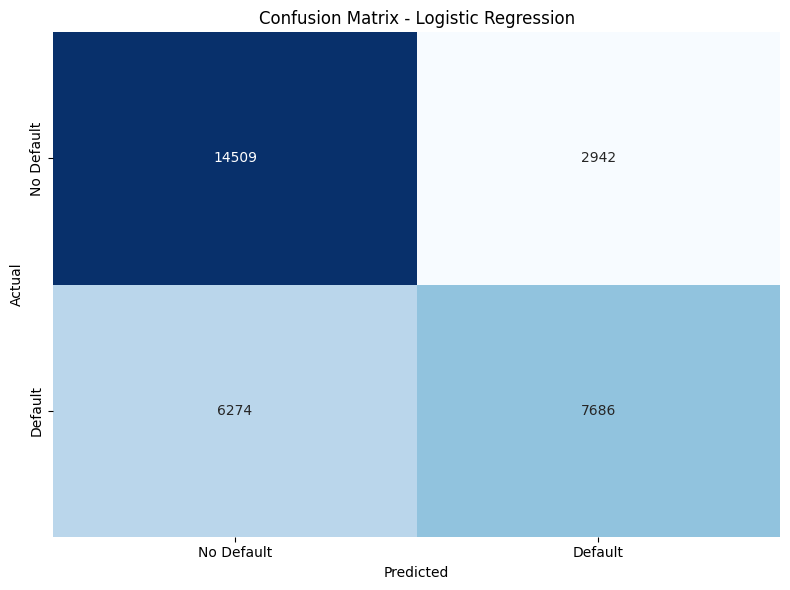

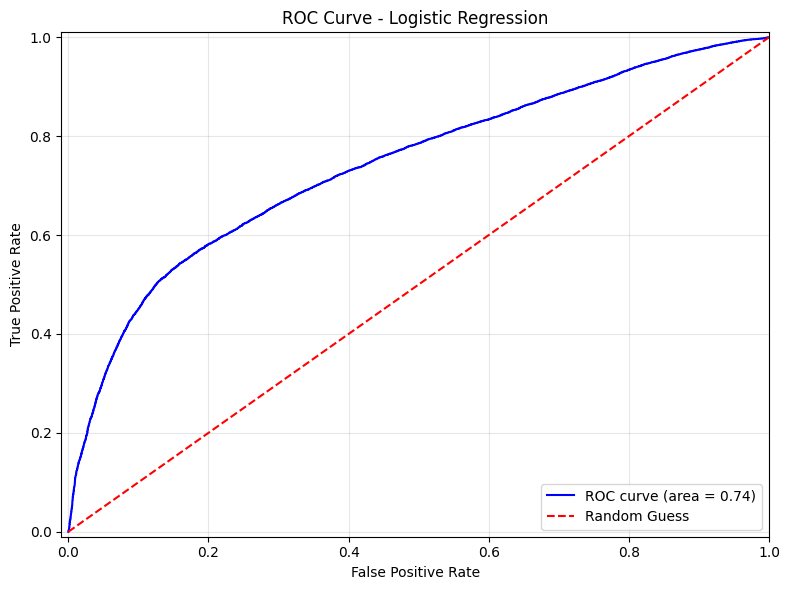

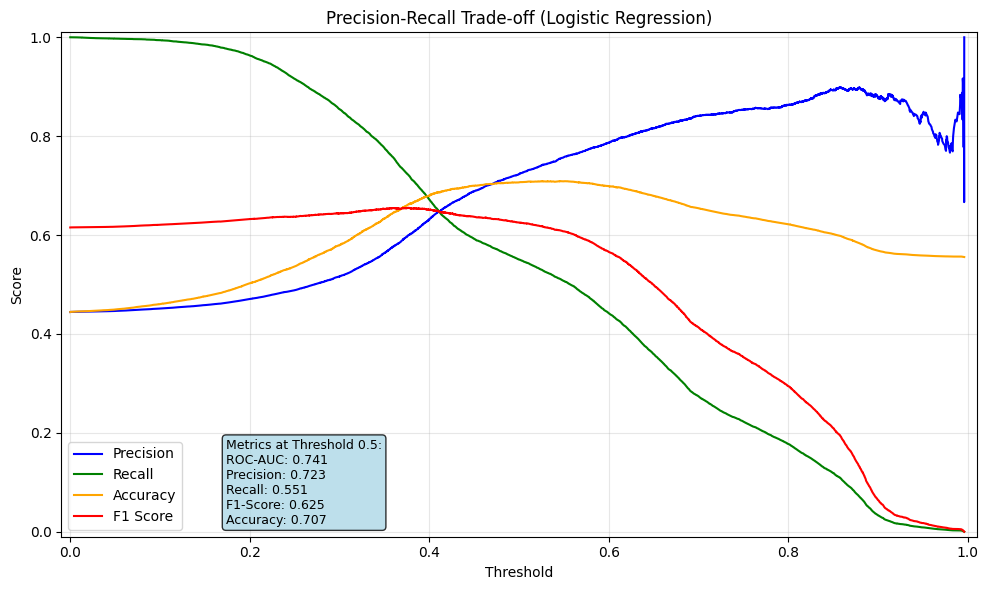

In [10]:
# Getting cross-validation predicted probabilities for positive (Default)class
y_pred_proba_cv_lr = cross_val_predict(logistic_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_lr, model_name='Logistic Regression', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_lr, model_name='Logistic Regression', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_lr, y_pred_cv_lr, model_name='Logistic Regression', save_path=validation_performace_outputs)

- Logistic Regression performs well with Area Under ROC Curve (AUC) of 74% and F1 score of 55% on validation dataset.
- The model has a precision of 72%, which means that when the model predicts a default payment, it is correct 72% of the time.
- The recall is 55%, indicating that the model identifies 55% of actual default payments. which is decent but could be improved.

## **2.2 Decision Tree Classifier Model**

In [11]:
# Finding the best parameters for decision tree using GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Defining the parameter grid for GridSearchCV
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Creating a Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_dt = GridSearchCV(decision_tree_model, param_grid_dt, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_dt = grid_search_dt.best_params_
best_params_dt

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5}

In [12]:
# Training the Decision Tree Classifier model on best hyperparameters
decision_tree_model = DecisionTreeClassifier(**best_params_dt, random_state=1)

# Getting cross-validation predictions
y_pred_cv_dt = cross_val_predict(decision_tree_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_dt = cross_val_score(decision_tree_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_dt = np.mean(cv_roc_auc_dt)
print(f"\nCross-validation roc auc: {cv_roc_auc_dt}")
print(f"\nmean roc auc: {mean_cv_roc_auc_dt:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_dt, precision_cv_dt, recall_cv_dt, f1_cv_dt, accuracy_cv_dt = calculate_performance_metrics(y_train, y_pred_cv_dt)
print(f"Precision: {precision_cv_dt:.4f}")
print(f"Recall: {recall_cv_dt:.4f}")
print(f"F1 Score: {f1_cv_dt:.4f}")
print(f"Accuracy: {accuracy_cv_dt:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_dt}")


Cross-validation roc auc: [0.7296 0.7525 0.8138 0.8406 0.8198]

mean roc auc: 0.7913
Precision: 0.7327
Recall: 0.6383
F1 Score: 0.6822
Accuracy: 0.7358

Confusion Matrix:
[[14201  3250]
 [ 5050  8910]]


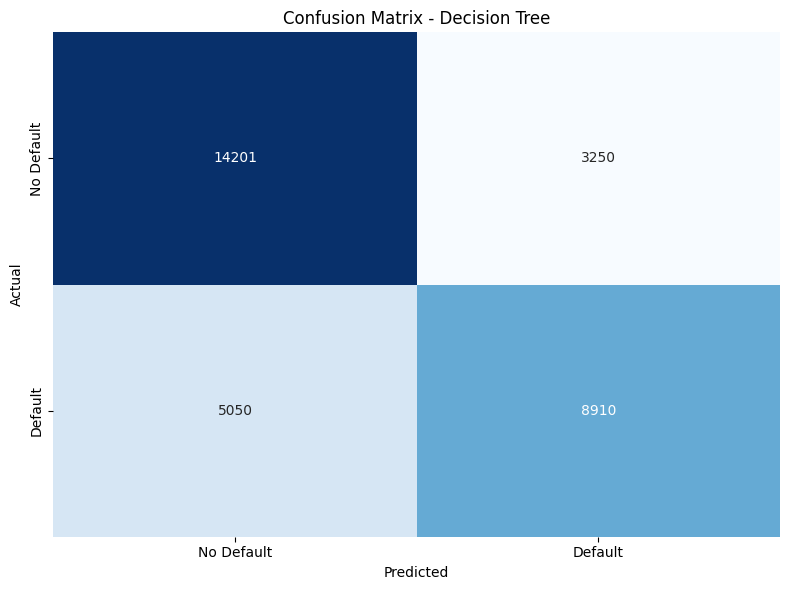

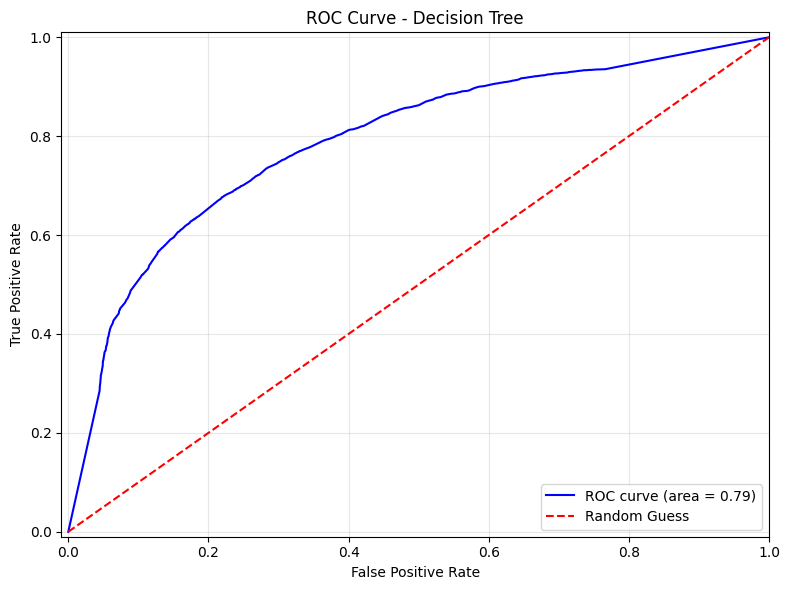

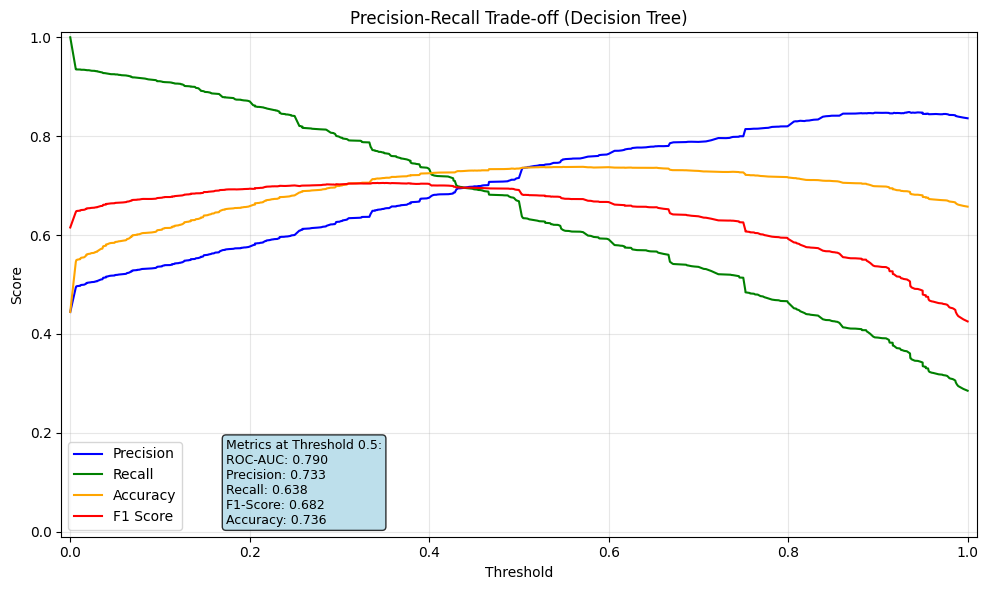

In [13]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_dt = cross_val_predict(decision_tree_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_dt, model_name='Decision Tree', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_dt, model_name='Decision Tree', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_dt, y_pred_cv_dt, model_name='Decision Tree', save_path=validation_performace_outputs)

- Decision Tree Classifier performs well with Area Under ROC Curve (AUC) of 79% and F1 score of 68% on validation dataset.
- The model has a precision of 73%, and recall of 63% which has also improved compared to Logistic Regression.

## **2.3 K-Nearest Neighbors (KNN) Model**

In [14]:
# Finding the best hyperparameters for K-Nearest Neighbors using GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Defining the parameter grid for GridSearchCV
param_grid_knn = {
    'n_neighbors': [5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Creating a K-Nearest Neighbors Classifier model
knn_model = KNeighborsClassifier()

# Performing GridSearchCV to find the best hyperparameters
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_knn = grid_search_knn.best_params_
best_params_knn

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [15]:
# Training the K-Nearest Neighbors model on best hyperparameters
knn_model = KNeighborsClassifier(**best_params_knn, n_jobs=-1)

# Getting cross-validation predictions
y_pred_cv_knn = cross_val_predict(knn_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_knn = cross_val_score(knn_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_knn = np.mean(cv_roc_auc_knn)
print(f"Cross-validation roc auc: {cv_roc_auc_knn}")
print(f"\nmean roc auc: {mean_cv_roc_auc_knn:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_knn, precision_cv_knn, recall_cv_knn, f1_cv_knn, accuracy_cv_knn = calculate_performance_metrics(y_train, y_pred_cv_knn)
print(f"Precision: {precision_cv_knn:.4f}")
print(f"Recall: {recall_cv_knn:.4f}")
print(f"F1 Score: {f1_cv_knn:.4f}")
print(f"Accuracy: {accuracy_cv_knn:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_knn}")

Cross-validation roc auc: [0.882  0.89   0.9244 0.9389 0.9307]

mean roc auc: 0.9132
Precision: 0.7531
Recall: 0.9120
F1 Score: 0.8250
Accuracy: 0.8280

Confusion Matrix:
[[13278  4173]
 [ 1229 12731]]


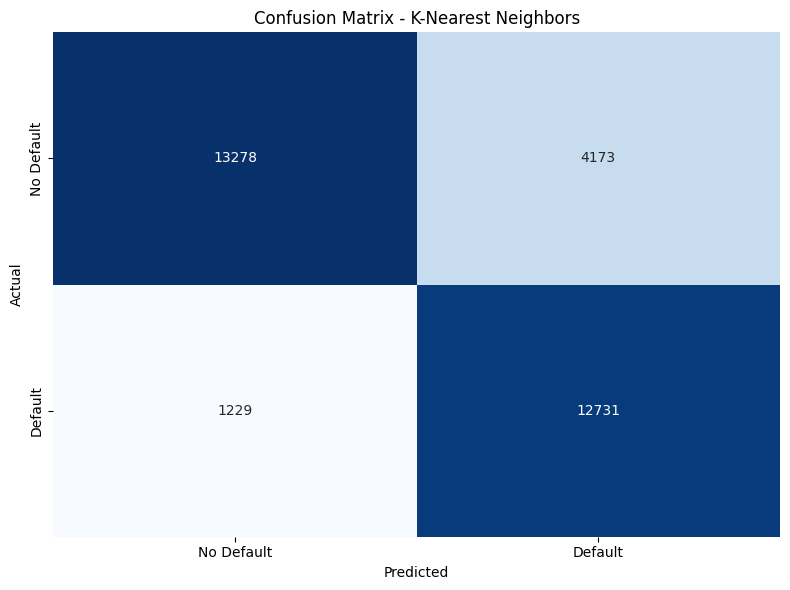

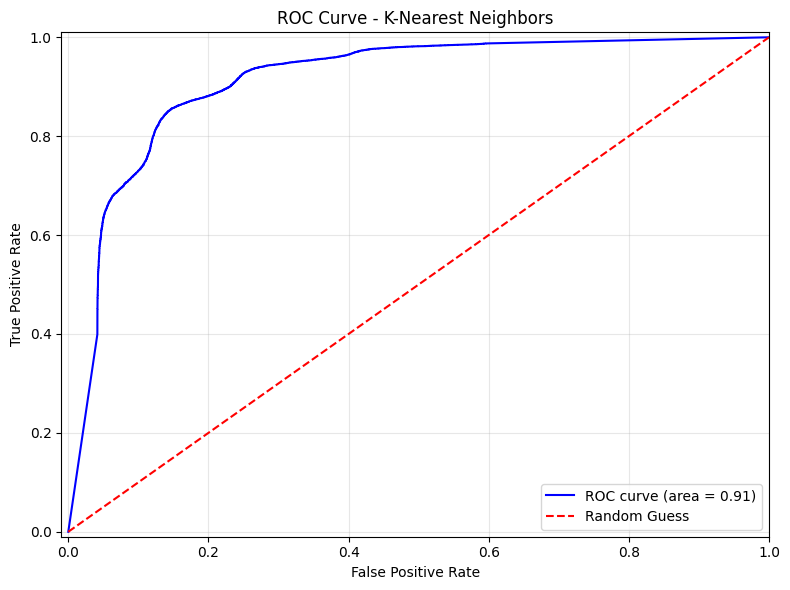

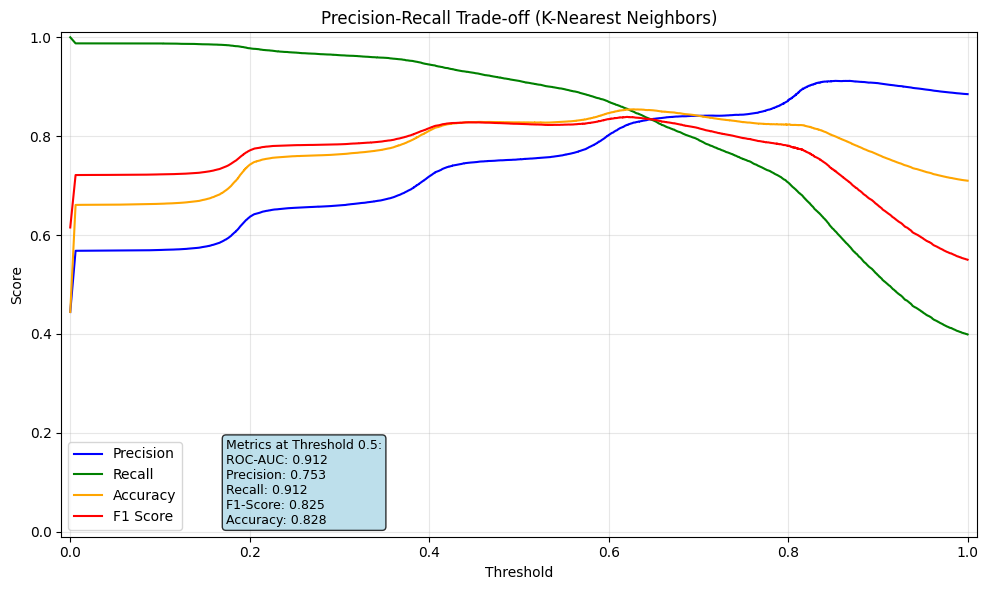

In [16]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_knn = cross_val_predict(knn_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_knn, model_name='K-Nearest Neighbors', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_knn, model_name='K-Nearest Neighbors', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_knn, y_pred_cv_knn, model_name='K-Nearest Neighbors', save_path=validation_performace_outputs)

- KNN Classifier performs very well with Area Under ROC Curve (AUC) of 91% and F1 score of 82% on validation dataset.
- The model has a precision of 75%, which is good and recall is 88.1% which is excellent, indicating that the model identifies 88.1% of actual default payments which is critical for this problem.

## **2.4 Random Forest Classifier Model**

In [17]:
# Finding best parameters for Random Forest Classifier using GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Defining the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Creating a Random Forest Classifier model
random_forest_model = RandomForestClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_rf = GridSearchCV(random_forest_model, param_grid_rf, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_rf = grid_search_rf.best_params_
best_params_rf

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [18]:
# Training a Random Forest Classifier model on best hyperparameters
random_forest_model = RandomForestClassifier(**best_params_rf, n_jobs=-1, random_state=1)

# Getting cross-validation predictions
y_pred_cv_rf = cross_val_predict(random_forest_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_rf = cross_val_score(random_forest_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_rf = np.mean(cv_roc_auc_rf)
print("Cross-validation roc auc:", cv_roc_auc_rf)
print(f"\nmean roc auc: {mean_cv_roc_auc_rf:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_rf, precision_cv_rf, recall_cv_rf, f1_cv_rf, accuracy_cv_rf = calculate_performance_metrics(y_train, y_pred_cv_rf)
print(f"Precision: {precision_cv_rf:.4f}")
print(f"Recall: {recall_cv_rf:.4f}")
print(f"F1 Score: {f1_cv_rf:.4f}")
print(f"Accuracy: {accuracy_cv_rf:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_rf}")

Cross-validation roc auc: [0.8386 0.8592 0.9223 0.9339 0.9256]

mean roc auc: 0.8959
Precision: 0.8458
Recall: 0.7148
F1 Score: 0.7748
Accuracy: 0.8153

Confusion Matrix:
[[15632  1819]
 [ 3982  9978]]


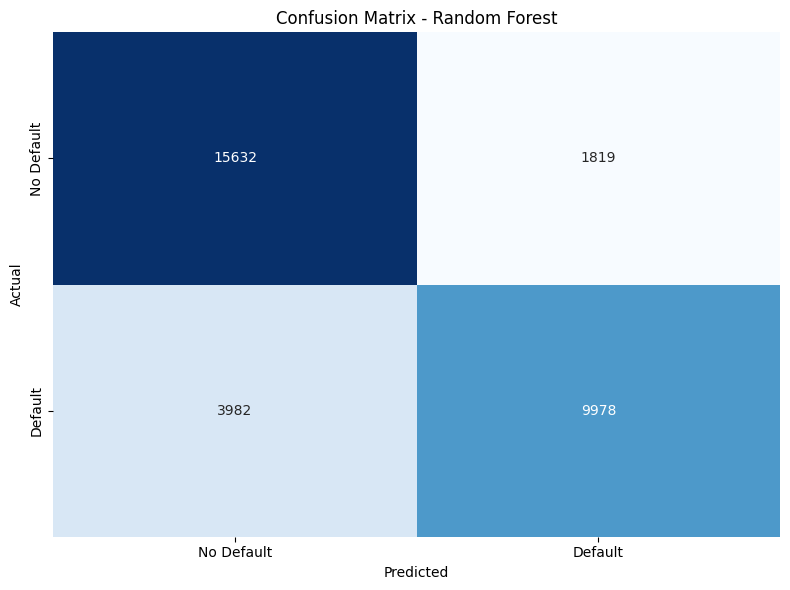

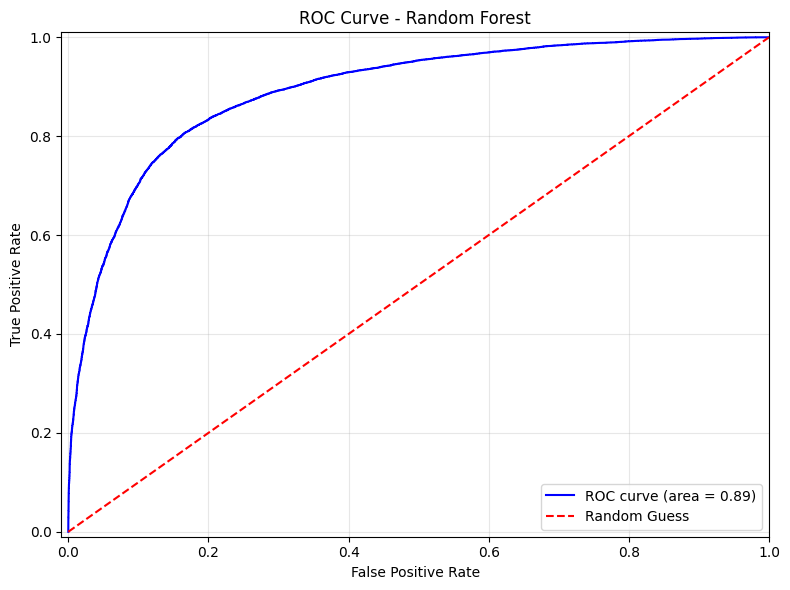

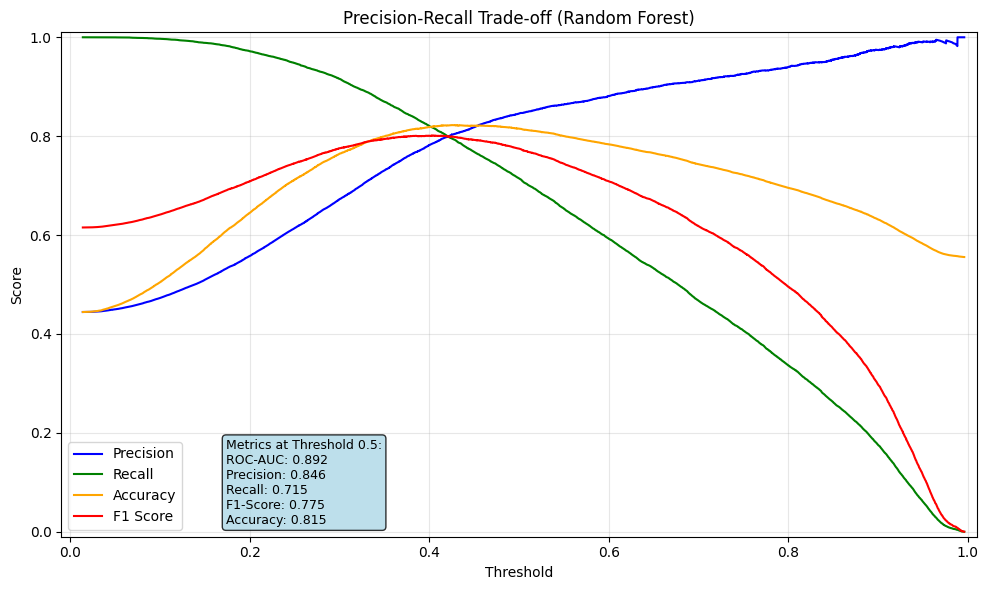

In [19]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_rf = cross_val_predict(random_forest_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_rf, model_name='Random Forest', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_rf, model_name='Random Forest', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_rf, y_pred_cv_rf, model_name='Random Forest', save_path=validation_performace_outputs)

- Random Forest Classifier performs very well with Area Under ROC Curve (AUC) of 89% and F1 score of 75.5% on validation dataset.
- The model has a precision of 84.6%, which means that when the model predicts a default payment, it is correct 84.6% of the time.
- The recall is 71.5%, indicating that the model identifies 71.5% of actual default payments, which is significantly better than both Logistic Regression and Decision Tree Classifier.

## **2.5 AdaBoost Classifier Model**

In [20]:
# Finding the best hyperparameters for AdaBoost using GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Defining the parameter grid for GridSearchCV
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Creating an AdaBoost Classifier model
ada_boost_model = AdaBoostClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_ab = GridSearchCV(ada_boost_model, param_grid_ab, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_ab.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_ab = grid_search_ab.best_params_
best_params_ab

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 200}

In [21]:
# Training an AdaBoost Classifier model on best hyperparameters
ada_boost_model = AdaBoostClassifier(**best_params_ab, random_state=1)

# Getting cross-validation predictions
y_pred_cv_ab = cross_val_predict(ada_boost_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_ab = cross_val_score(ada_boost_model, X_train, y_train, cv=5, scoring='roc_auc').round(4)
mean_cv_roc_auc_ab = np.mean(cv_roc_auc_ab)
print(f"\nCross-validation roc auc: {cv_roc_auc_ab}")
print(f"\nmean roc auc: {mean_cv_roc_auc_ab:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_ab, precision_cv_ab, recall_cv_ab, f1_cv_ab, accuracy_cv_ab = calculate_performance_metrics(y_train, y_pred_cv_ab)
print(f"Precision: {precision_cv_ab:.4f}")
print(f"Recall: {recall_cv_ab:.4f}")
print(f"F1 Score: {f1_cv_ab:.4f}")
print(f"Accuracy: {accuracy_cv_ab:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_ab}")


Cross-validation roc auc: [0.765  0.7989 0.9083 0.9093 0.9012]

mean roc auc: 0.8565
Precision: 0.8339
Recall: 0.6468
F1 Score: 0.7286
Accuracy: 0.7858

Confusion Matrix:
[[15653  1798]
 [ 4930  9030]]


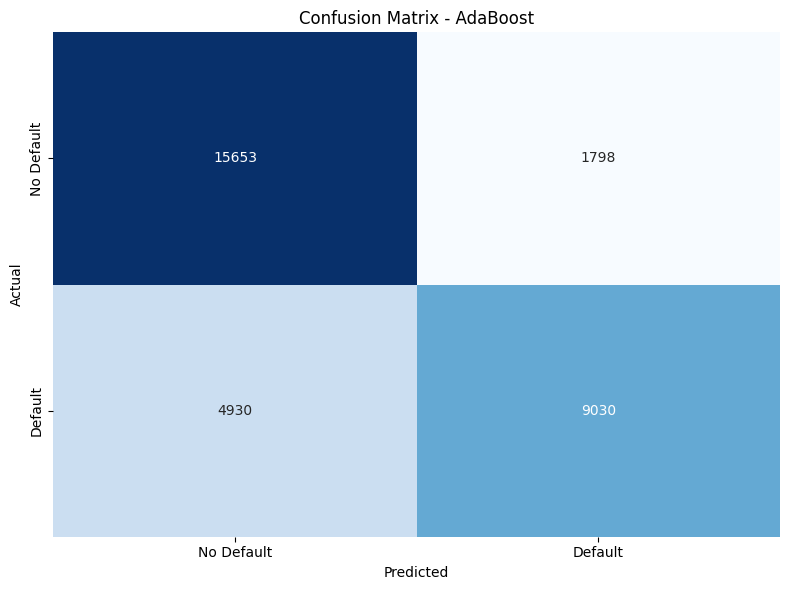

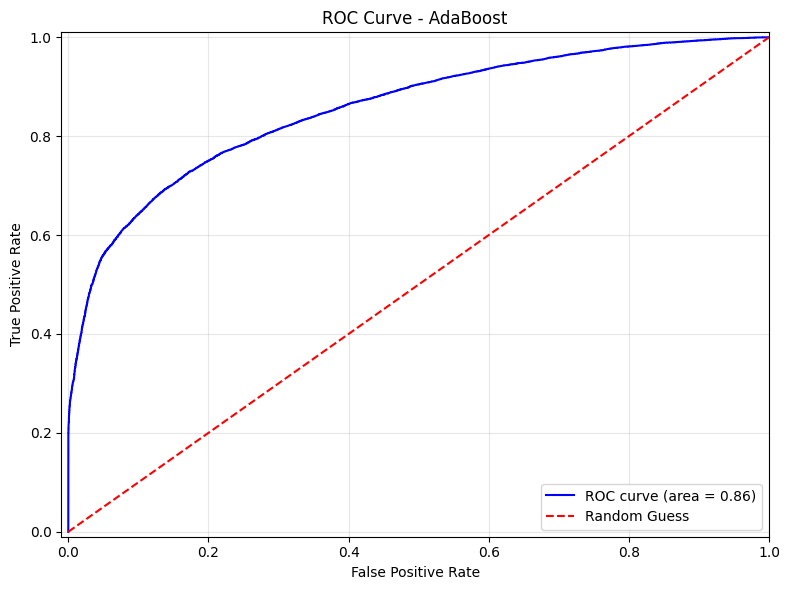

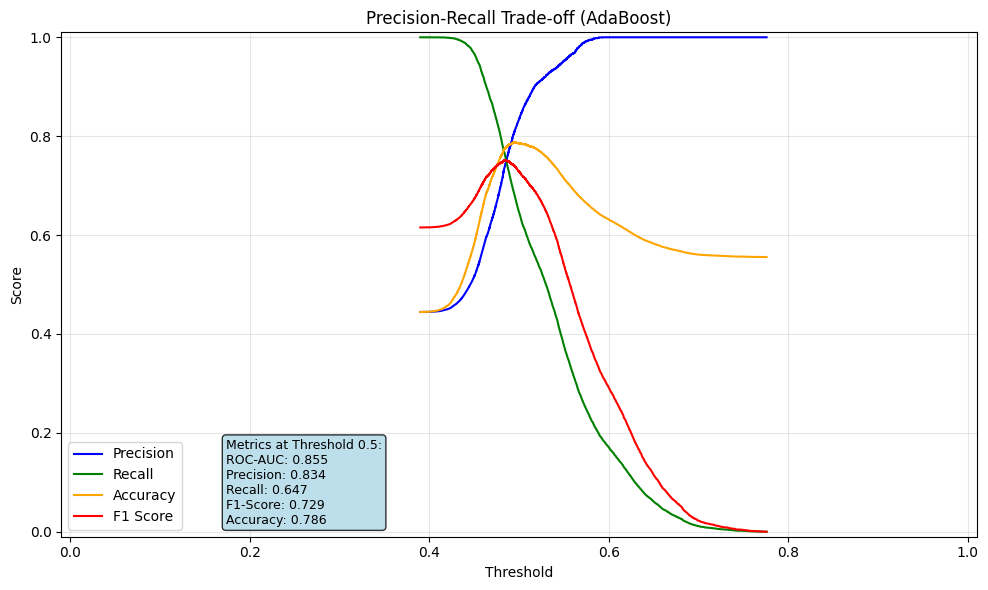

In [22]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_ab = cross_val_predict(ada_boost_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_ab, model_name='AdaBoost', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_ab, model_name='AdaBoost', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_ab, y_pred_cv_ab, model_name='AdaBoost', save_path=validation_performace_outputs)

- AdaBoost Classifier performs well with Area Under ROC Curve (AUC) of 85.5% and F1 score of 73% on validation dataset.
- The model has a precision of 83%, which means that when the model predicts a default payment, it is correct 83% of the time.
- The recall is 65%, indicating that the model identifies 65% of actual default payments, which is better than Logistic Regression's recall but lower than Decision Tree and KNN.

## **2.6 Gradient Boosting Classifier Model**

In [23]:
# Finding the best parameters for Gradient Boosting Classifier using GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Defining the parameter grid for GridSearchCV
param_grid_gb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

# Creating a Gradient Boosting Classifier model
gradient_boosting_model = GradientBoostingClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_gb = GridSearchCV(gradient_boosting_model, param_grid_gb, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_gb = grid_search_gb.best_params_
best_params_gb

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 300}

In [24]:
# Training a Gradient Boosting Classifier model on best hyperparameters
gradient_boosting_model = GradientBoostingClassifier(**best_params_gb, random_state=1)

# Getting cross-validation predictions
y_pred_cv_gb = cross_val_predict(gradient_boosting_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_gb = cross_val_score(gradient_boosting_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_gb = np.mean(cv_roc_auc_gb)
print(f"Cross-validation roc auc:", cv_roc_auc_gb)
print(f"\nmean roc auc: {mean_cv_roc_auc_gb:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_gb, precision_cv_gb, recall_cv_gb, f1_cv_gb, accuracy_cv_gb = calculate_performance_metrics(y_train, y_pred_cv_gb)
print(f"Precision: {precision_cv_gb:.4f}")
print(f"Recall: {recall_cv_gb:.4f}")
print(f"F1 Score: {f1_cv_gb:.4f}")
print(f"Accuracy: {accuracy_cv_gb:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_gb}")

Cross-validation roc auc: [0.7982 0.8413 0.9797 0.9822 0.9786]

mean roc auc: 0.9160
Precision: 0.8786
Recall: 0.7458
F1 Score: 0.8068
Accuracy: 0.8412

Confusion Matrix:
[[16013  1438]
 [ 3549 10411]]


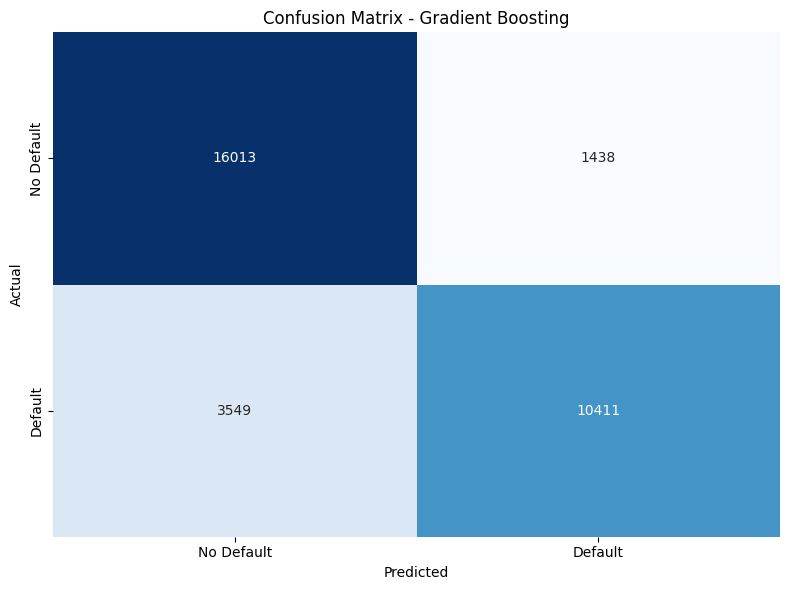

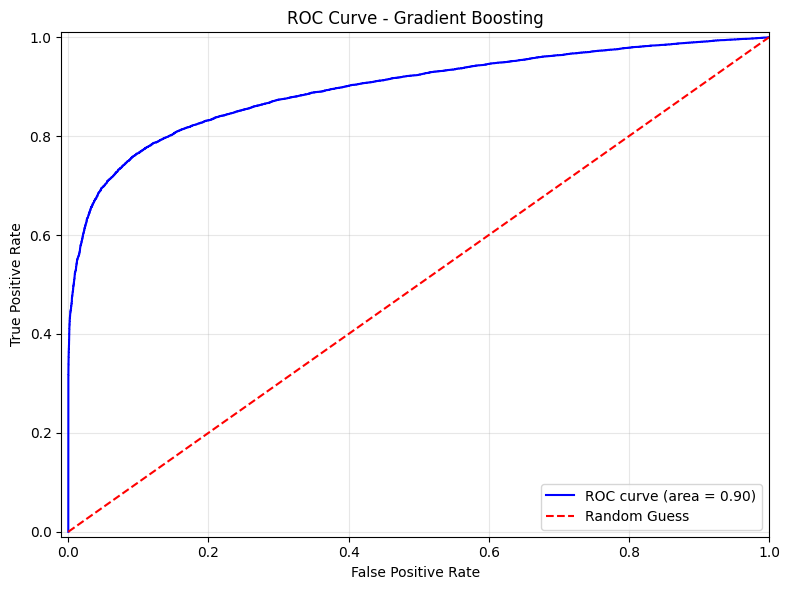

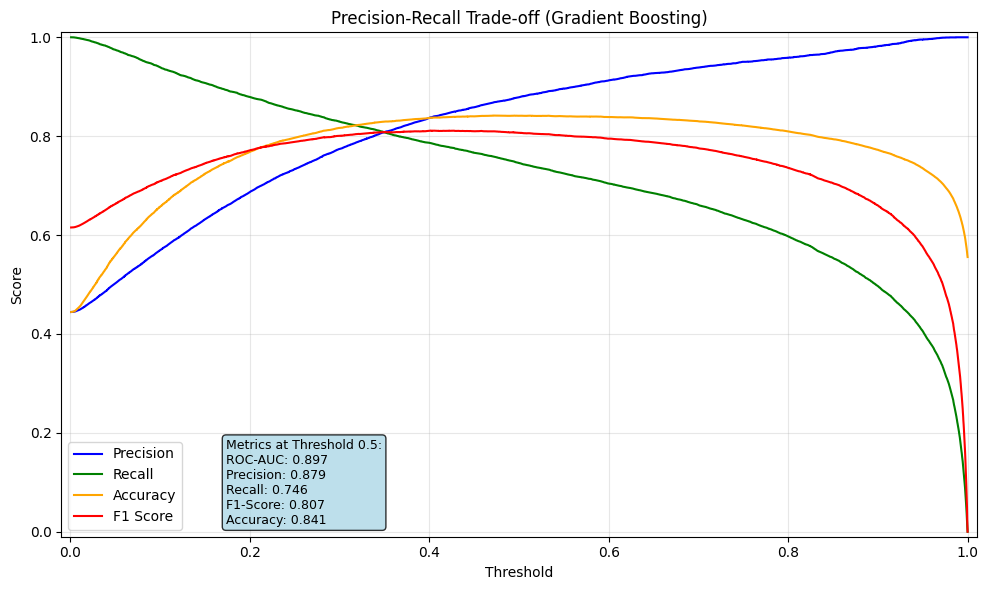

In [25]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_gb = cross_val_predict(gradient_boosting_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_gb, model_name='Gradient Boosting', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_gb, model_name='Gradient Boosting', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_gb, y_pred_cv_gb, model_name='Gradient Boosting', save_path=validation_performace_outputs)

- Gradient Boosting Classifier performs very well with Area Under ROC Curve (AUC) of 90% and F1 score of 80% on validation dataset.
- The model has a precision of 88%, which means that when the model predicts a default payment, it is correct 88% of the time.
- The recall is 74.6%, indicating that the model identifies 74.6% of actual default payments, which is significantly better than both Logistic Regression and Decision Tree Classifier.

## **2.7 XGBoost Classifier Model**

In [26]:
# Finding the best parameters for XGBoost using GridSearchCV
from xgboost import XGBClassifier

# Defining the parameter grid for GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2]
}

# Creating an XGBoost Classifier model
xgboost_model = XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss')

# Performing GridSearchCV to find the best hyperparameters
grid_search_xgb = GridSearchCV(xgboost_model, param_grid_xgb, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_xgb = grid_search_xgb.best_params_
best_params_xgb

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 300,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [27]:
# Training a XGBoost Classifier model on best hyperparameters
xgboost_model = XGBClassifier(**best_params_xgb, random_state=1, use_label_encoder=False, eval_metric='logloss')

# Getting cross-validation predictions
y_pred_cv_xgb = cross_val_predict(xgboost_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_xgb = cross_val_score(xgboost_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_xgb = np.mean(cv_roc_auc_xgb)
print(f"\nCross-validation roc auc: {cv_roc_auc_xgb}")
print(f"\nmean roc auc: {mean_cv_roc_auc_xgb:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_xgb, precision_cv_xgb, recall_cv_xgb, f1_cv_xgb, accuracy_cv_xgb = calculate_performance_metrics(y_train, y_pred_cv_xgb)
print(f"Precision: {precision_cv_xgb:.4f}")
print(f"Recall: {recall_cv_xgb:.4f}")
print(f"F1 Score: {f1_cv_xgb:.4f}")
print(f"Accuracy: {accuracy_cv_xgb:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_xgb}")


Cross-validation roc auc: [0.7913 0.8367 0.9813 0.9839 0.9803]

mean roc auc: 0.9147
Precision: 0.8805
Recall: 0.7408
F1 Score: 0.8047
Accuracy: 0.8402

Confusion Matrix:
[[16048  1403]
 [ 3618 10342]]


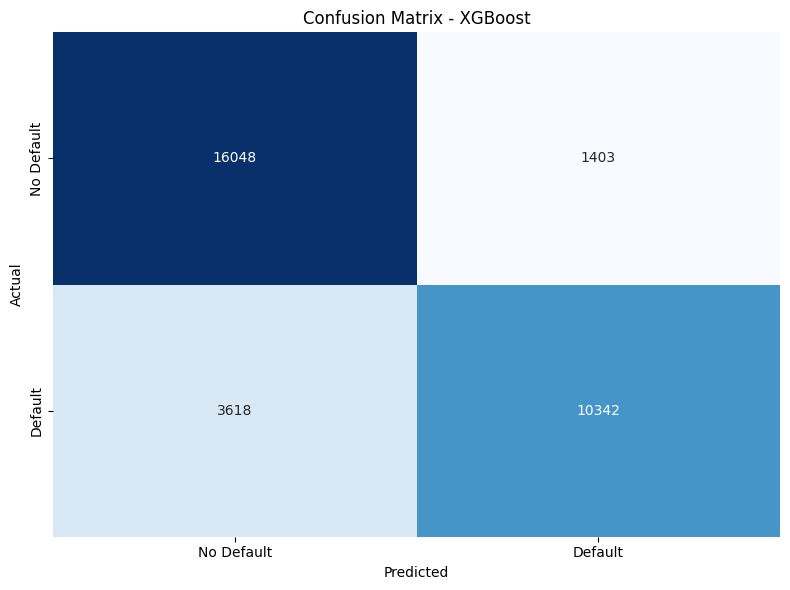

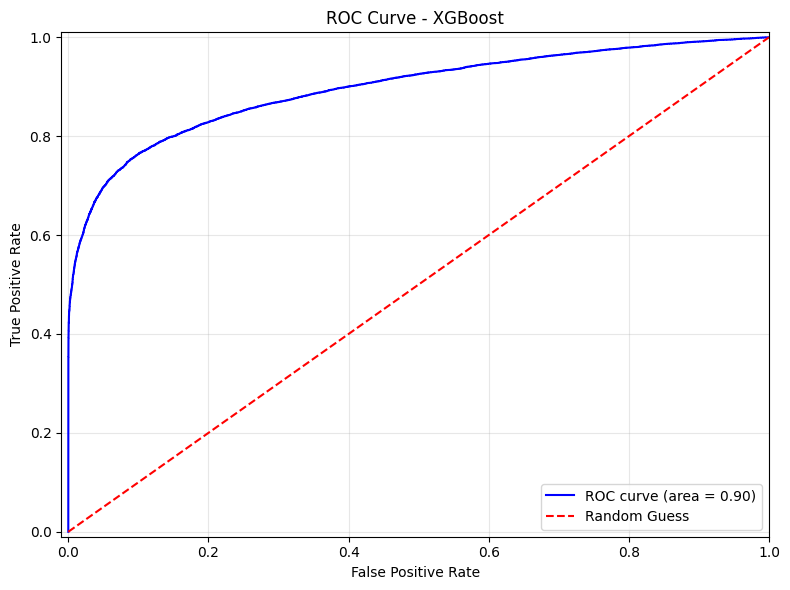

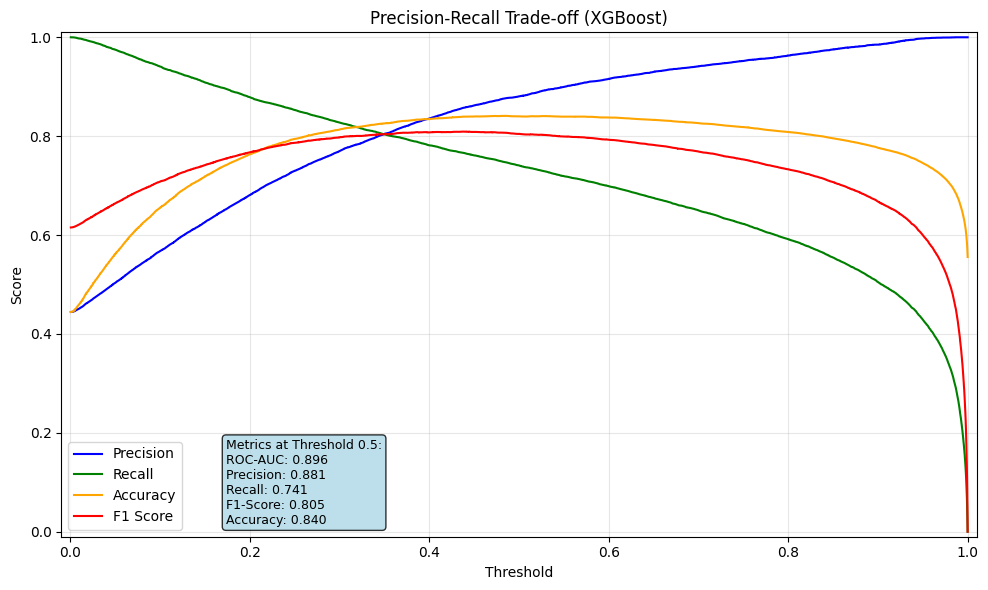

In [28]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_xgb = cross_val_predict(xgboost_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_xgb, model_name='XGBoost', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_xgb, model_name='XGBoost', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_xgb, y_pred_cv_xgb, model_name='XGBoost', save_path=validation_performace_outputs)

- XGBoost Classifier performs very well with Area Under ROC Curve (AUC) of 90% and F1 score of 80% on validation dataset.
- The model has a precision of 88%, which means that when the model predicts a default payment, it is correct 88% of the time.
- The recall is 74%, indicating that the model identifies 74% of actual default payments, which is significantly better than both Logistic Regression and Decision Tree Classifier.

## **Performance comparison of all models**

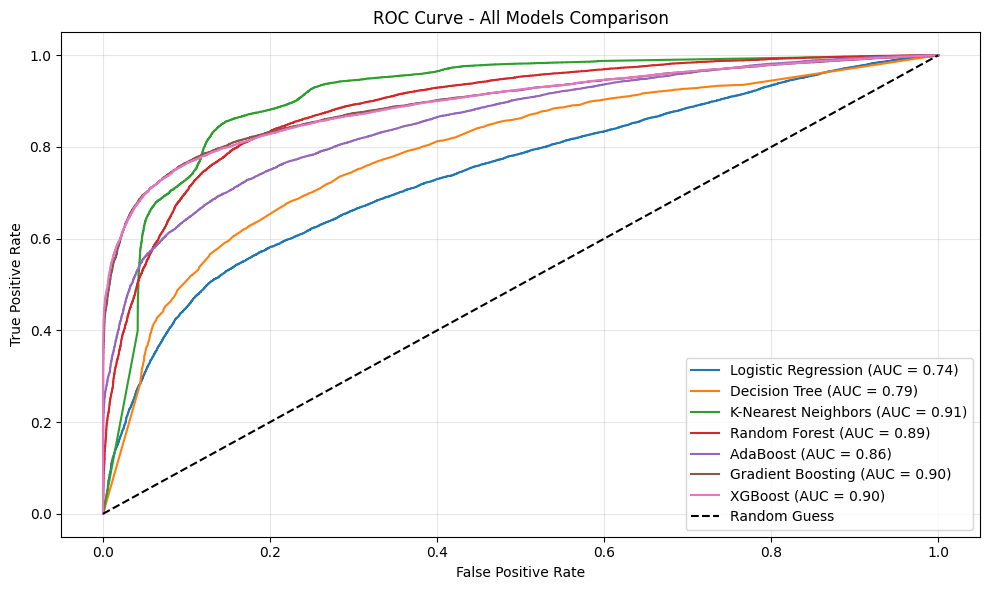

In [29]:
# Calculating fpr, tpr, and roc_auc for all models
fpr_cv_lr, tpr_cv_lr, roc_auc_cv_lr = calculate_roc_auc(y_train, y_pred_proba_cv_lr)
fpr_cv_dt, tpr_cv_dt, roc_auc_cv_dt = calculate_roc_auc(y_train, y_pred_proba_cv_dt)
fpr_cv_knn, tpr_cv_knn, roc_auc_cv_knn = calculate_roc_auc(y_train, y_pred_proba_cv_knn)
fpr_cv_rf, tpr_cv_rf, roc_auc_cv_rf = calculate_roc_auc(y_train, y_pred_proba_cv_rf)
fpr_cv_ab, tpr_cv_ab, roc_auc_cv_ab = calculate_roc_auc(y_train, y_pred_proba_cv_ab)
fpr_cv_gb, tpr_cv_gb, roc_auc_cv_gb = calculate_roc_auc(y_train, y_pred_proba_cv_gb)
fpr_cv_xgb, tpr_cv_xgb, roc_auc_cv_xgb = calculate_roc_auc(y_train, y_pred_proba_cv_xgb)


# Ploting ROC AUC for all models
plt.figure(figsize=(10, 6))
plt.plot(fpr_cv_lr, tpr_cv_lr, label=f'Logistic Regression (AUC = {roc_auc_cv_lr:.2f})')
plt.plot(fpr_cv_dt, tpr_cv_dt, label=f'Decision Tree (AUC = {roc_auc_cv_dt:.2f})')
plt.plot(fpr_cv_knn, tpr_cv_knn, label=f'K-Nearest Neighbors (AUC = {roc_auc_cv_knn:.2f})')
plt.plot(fpr_cv_rf, tpr_cv_rf, label=f'Random Forest (AUC = {roc_auc_cv_rf:.2f})')
plt.plot(fpr_cv_ab, tpr_cv_ab, label=f'AdaBoost (AUC = {roc_auc_cv_ab:.2f})')    
plt.plot(fpr_cv_gb, tpr_cv_gb, label=f'Gradient Boosting (AUC = {roc_auc_cv_gb:.2f})')
plt.plot(fpr_cv_xgb, tpr_cv_xgb, label=f'XGBoost (AUC = {roc_auc_cv_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "roc_curve_comparison.png"))
plt.show()

- Based on the Area Under ROC Curve (AUC) scores, the KNN Classifier (90%), Random Forest Classifier (89%) models , Gradient Boosting Classifier (89%) and XGBoost Classifier (89%) performed the best. followed closely by AdaBoost Classifier (86.7%).

In [30]:
# Creating a summary dataframe for model performance
model_performance = {
    'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors', 
              'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'ROC AUC': [roc_auc_cv_lr, roc_auc_cv_dt, roc_auc_cv_knn, 
                roc_auc_cv_rf, roc_auc_cv_ab, roc_auc_cv_gb, roc_auc_cv_xgb],
    'Precision': [precision_cv_lr, precision_cv_dt, precision_cv_knn,
                    precision_cv_rf, precision_cv_ab, precision_cv_gb, precision_cv_xgb],
    'Recall': [recall_cv_lr, recall_cv_dt, recall_cv_knn,
                recall_cv_rf, recall_cv_ab, recall_cv_gb, recall_cv_xgb],
    'F1 Score': [f1_cv_lr, f1_cv_dt, f1_cv_knn,
                    f1_cv_rf, f1_cv_ab, f1_cv_gb, f1_cv_xgb],
    'Accuracy': [accuracy_cv_lr, accuracy_cv_dt, accuracy_cv_knn,
                    accuracy_cv_rf, accuracy_cv_ab, accuracy_cv_gb, accuracy_cv_xgb]
}

model_performance_df = pd.DataFrame(model_performance)
model_performance_df = model_performance_df.sort_values(by='ROC AUC', ascending=False, ignore_index=True)

# Saving the model performance summary to a CSV file
csv_output_dir = "csv_outputs"
os.makedirs(csv_output_dir, exist_ok=True)
model_performance_df.to_csv(os.path.join(csv_output_dir, "model_performance_summary_validation.csv"), index=False)

# Displaying the model performance summary
model_performance_df

,Model,ROC AUC,Precision,Recall,F1 Score,Accuracy
0,K-Nearest Neighbors,0.912478,0.753135,0.911963,0.824974,0.828022
1,Gradient Boosting,0.896678,0.878640,0.745774,0.806773,0.841234
2,XGBoost,0.896233,0.880545,0.740831,0.804668,0.840152
3,Random Forest,0.892226,0.845808,0.714756,0.774780,0.815319
4,AdaBoost,0.855420,0.833949,0.646848,0.728578,0.785808
5,Decision Tree,0.789869,0.732730,0.638252,0.682236,0.735761
6,Logistic Regression,0.741295,0.723184,0.550573,0.625183,0.706600


- Based on the model performance on validation data, we will select **KNN Classifier**, **Random Forest Classifier**, **Gradient Boosting Classifier**, and **XGBoost Classifier** and try to test them on the test dataset to see how they perform on unseen data.
- As these models have shown the best performance in terms of AUC, Recall, , and F1 score, they are likely to generalize well to new data.

# **3. Model Evaluation on Test Set**

In [31]:
# loading the test data
test_data_path = os.path.join(csv_output_dir, "test_data.npy")

# Reading the test array from the .npy file
test_arr = np.load(test_data_path, allow_pickle=True)

# Splitting the data into X_test and y_test
X_test = test_arr[:, :-1]
y_test = test_arr[:, -1]

# Displaying the shapes of X_test and y_test
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_test: (7469, 28)
y_test: (7469,)


In [32]:
# Defining the path to the CSV output directory for test performance outputs
test_performace_outputs = "test_performance_outputs"
os.makedirs(test_performace_outputs, exist_ok=True)

## **3.1 Testing KNN Classifier Model**

In [33]:
best_params_knn

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [34]:
# Training the K-Nearest Neighbors model on best hyperparameters
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=5, 
                                 weights='distance', n_jobs=-1)

# Fitting the K-Nearest Neighbors model on the training data
knn_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Calculating performance metrics for the KNN Classifier on the test set
cm_knn, precision_knn, recall_knn, f1_knn, accuracy_knn = calculate_performance_metrics(y_test, y_pred_knn)
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"\nConfusion Matrix:\n{cm_knn}")

Precision: 0.3750
Recall: 0.5212
F1 Score: 0.4362
Accuracy: 0.7020

Confusion Matrix:
[[4382 1435]
 [ 791  861]]


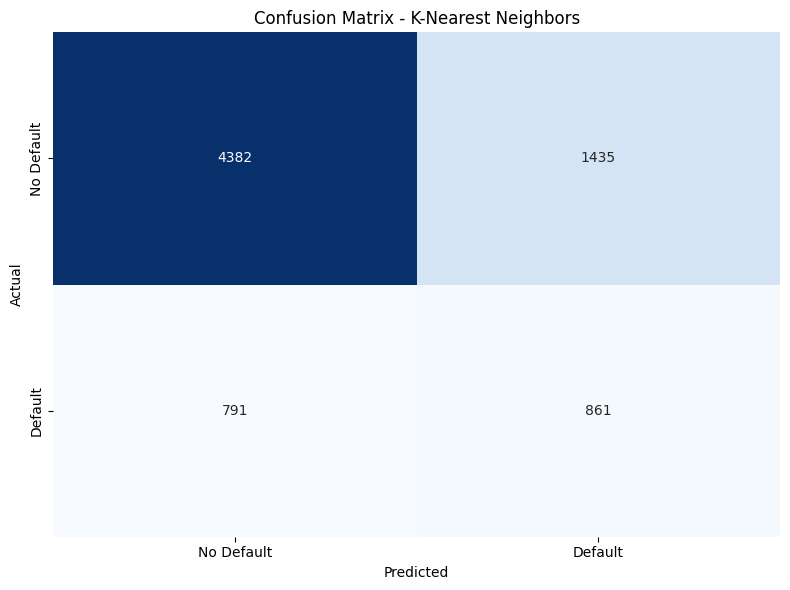

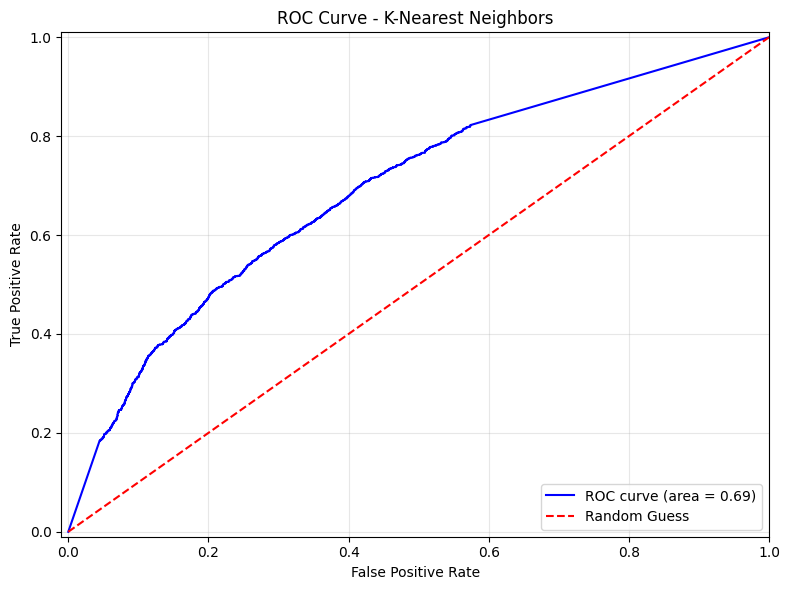

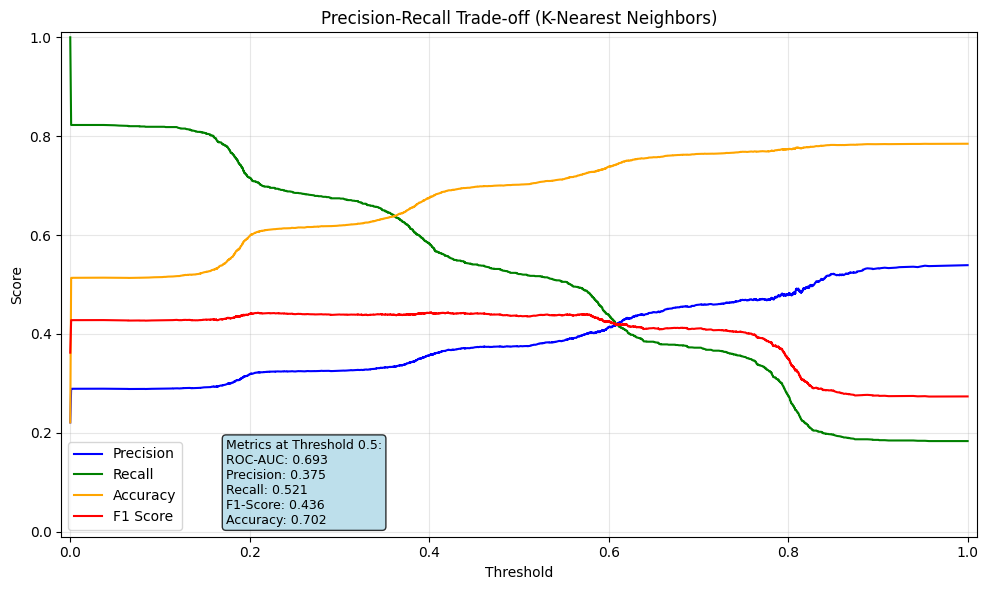

In [35]:
# Getting predicted probabilities for positive (Default) class
y_pred_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# Plotting the confusion matrix for KNN Classifier
plot_confusion_matrix(cm_knn, model_name='K-Nearest Neighbors', save_path=test_performace_outputs)

# Plotting the ROC curve for KNN Classifier
plot_roc_curve(y_test, y_pred_proba_knn, model_name='K-Nearest Neighbors', save_path=test_performace_outputs)

# Plotting the Precision-Recall Trade-off for KNN Classifier
plot_precision_recall_tradeoff(y_test, y_pred_proba_knn, y_pred_knn, model_name='K-Nearest Neighbors', save_path=test_performace_outputs)

- KNN Clasifer performance on test (unseen) data is very low compared to validation data.
- The model has ROC-AUC of 69%, F1 score of 0.43, precision of 0.37, and recall of 0.52 indicating that the model is not generalizing well to unseen data.
- The model is overfitting on the validation data and not performing well on the test data

## **3.2 Testing Random Forest Classifier Model**

In [36]:
best_params_rf

{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [37]:
# Training the Random Forest model on best hyperparameters
rf_model = RandomForestClassifier(max_depth=15, max_features='sqrt', 
                                  min_samples_leaf=2, min_samples_split=5, 
                                  n_estimators=200, n_jobs=-1, random_state=1)

# Fitting the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculating performance metrics for the Random Forest Classifier on the test set
cm_rf, precision_rf, recall_rf, f1_rf, accuracy_rf = calculate_performance_metrics(y_test, y_pred_rf)
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"\nConfusion Matrix:\n{cm_rf}")

Precision: 0.5700
Recall: 0.4831
F1 Score: 0.5229
Accuracy: 0.8051

Confusion Matrix:
[[5215  602]
 [ 854  798]]


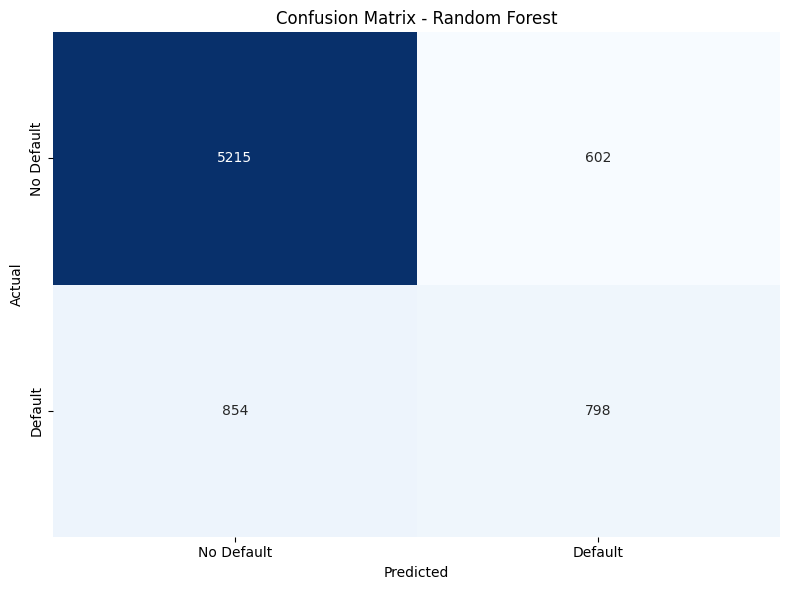

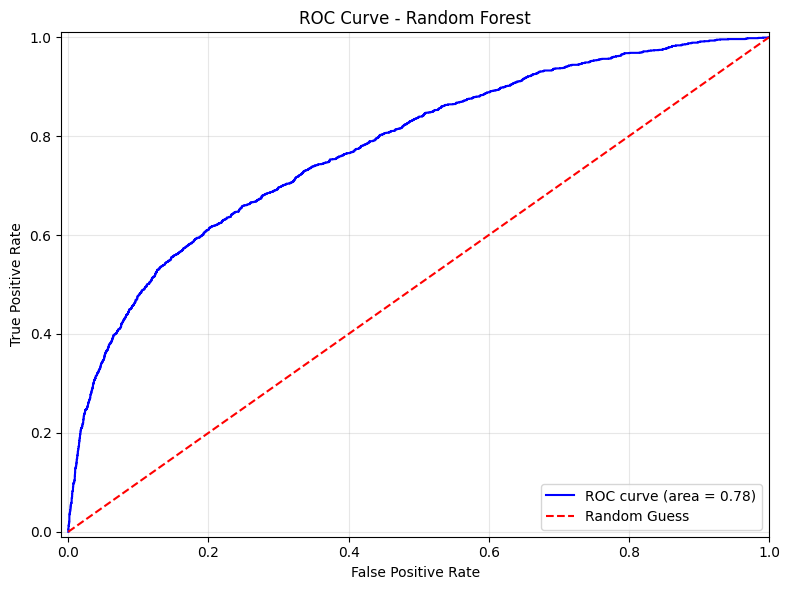

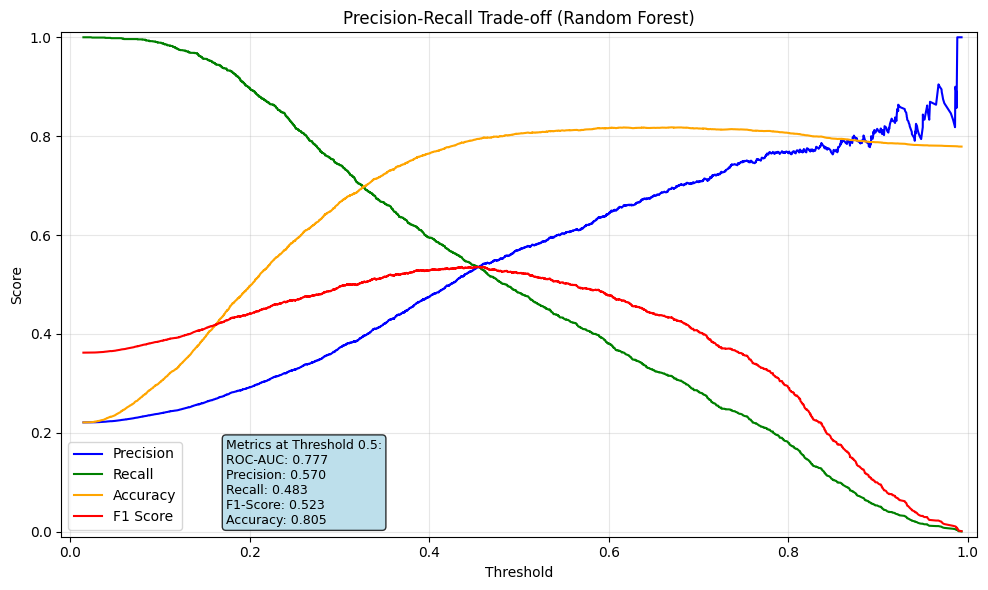

In [38]:
# Getting predicted probabilities for positive (Default) class
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Plotting the confusion matrix for Random Forest Classifier
plot_confusion_matrix(cm_rf, model_name='Random Forest', save_path=test_performace_outputs)

# Plotting the ROC curve for Random Forest Classifier
plot_roc_curve(y_test, y_pred_proba_rf, model_name='Random Forest', save_path=test_performace_outputs)

# Plotting the Precision-Recall Trade-off for Random Forest Classifier
plot_precision_recall_tradeoff(y_test, y_pred_proba_rf, y_pred_rf, model_name='Random Forest', save_path=test_performace_outputs)

- Random Forest Classifier performs better than KNN Classifier with Area Under ROC Curve (AUC) of 77.7% and F1 score of 52% on test dataset.
- The model has a precision of 57% and recall of 48%, indicating moderate performance on test data.

## **3.3 Testing Gradient Boosting Classifier Model**

In [39]:
best_params_gb

{'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 300}

In [40]:
# Training the Gradient Boosting model on best hyperparameters
gb_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=7,
                                      max_features='log2', min_samples_leaf=4, 
                                      min_samples_split=3, n_estimators=300, random_state=1)

# Fitting the Gradient Boosting model on the training data
gb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Calculating performance metrics for the Gradient Boosting Classifier on the test set
cm_gb, precision_gb, recall_gb, f1_gb, accuracy_gb = calculate_performance_metrics(y_test, y_pred_gb)
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1 Score: {f1_gb:.4f}")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"\nConfusion Matrix:\n{cm_gb}")

Precision: 0.5855
Recall: 0.4104
F1 Score: 0.4826
Accuracy: 0.8053

Confusion Matrix:
[[5337  480]
 [ 974  678]]


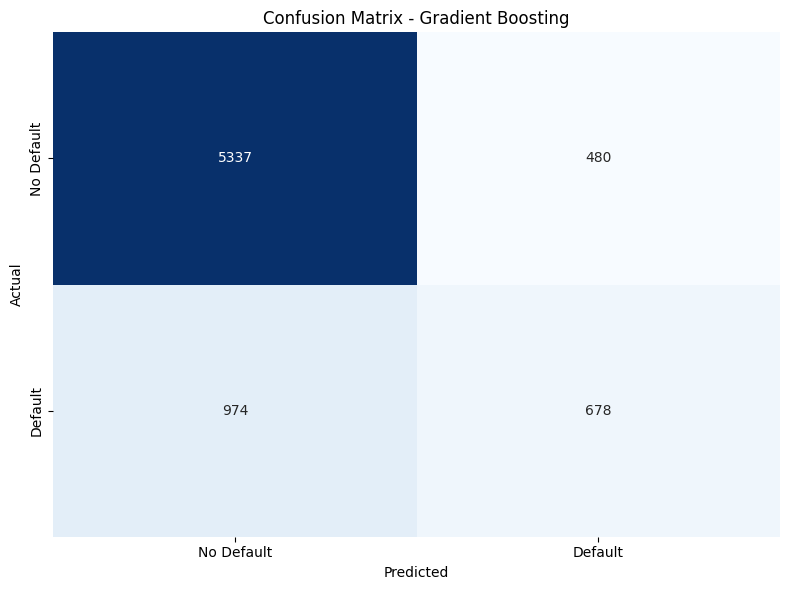

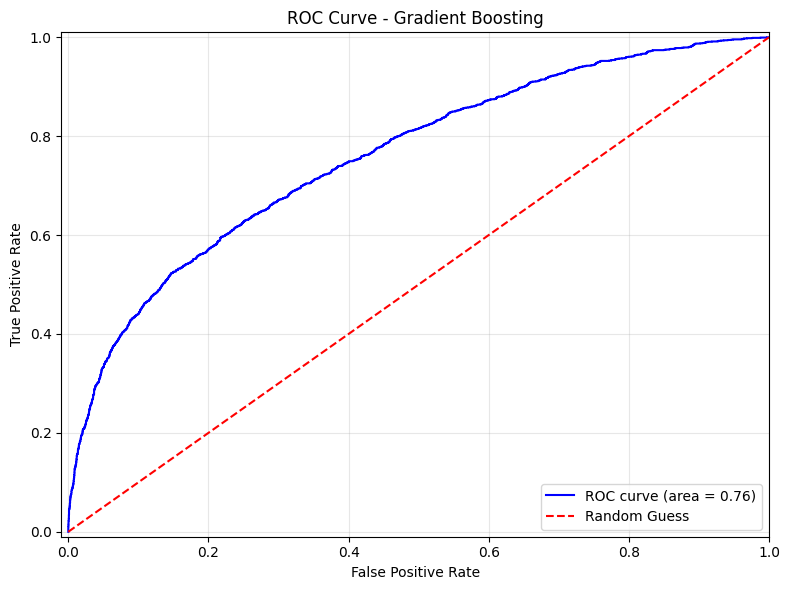

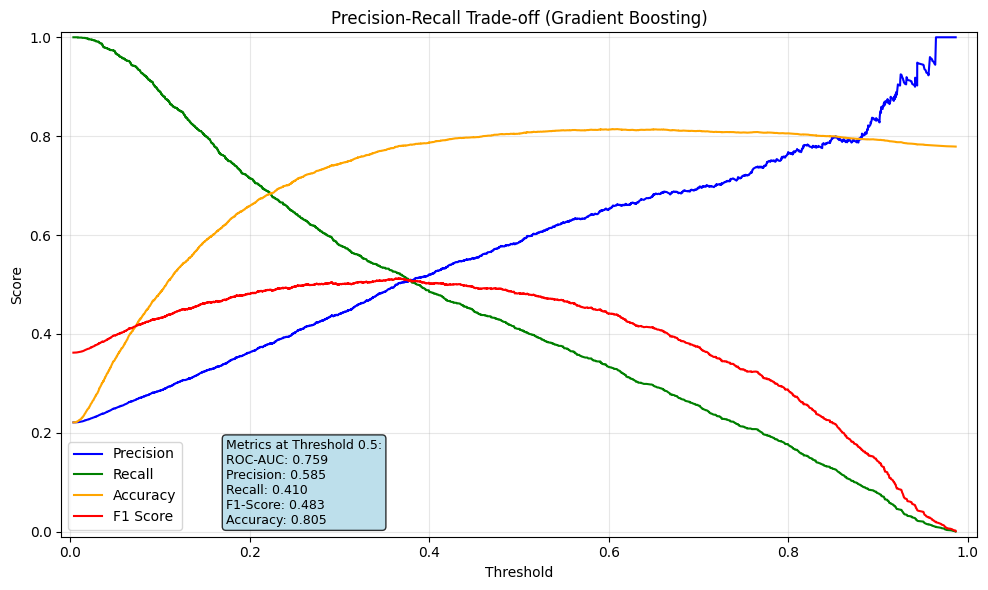

In [41]:
# Getting predicted probabilities for positive (Default) class
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Plotting the confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(cm_gb, model_name='Gradient Boosting', save_path=test_performace_outputs)

# Plotting the ROC curve for Gradient Boosting Classifier
plot_roc_curve(y_test, y_pred_proba_gb, model_name='Gradient Boosting', save_path=test_performace_outputs)

# Plotting the Precision-Recall Trade-off for Gradient Boosting Classifier
plot_precision_recall_tradeoff(y_test, y_pred_proba_gb, y_pred_gb, model_name='Gradient Boosting', save_path=test_performace_outputs)

- Gradient Boosting Classifier performs decently with Area Under ROC Curve (AUC) of 76% and F1 score of 58% on test dataset.
- The model has a precision of 58% and recall of 41%, indicating low performance on test data.

## **3.4 Testing XGBoost Classifier Model**

In [42]:
best_params_xgb

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 300,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [43]:
# Training the XGBoost model on best hyperparameters
xgb_model = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, 
                          n_estimators=300, scale_pos_weight=2, subsample=0.8, 
                          random_state=1, use_label_encoder=False, eval_metric='logloss')

# Fitting the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculating performance metrics for the XGBoost Classifier on the test set
cm_xgb, precision_xgb, recall_xgb, f1_xgb, accuracy_xgb = calculate_performance_metrics(y_test, y_pred_xgb)
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"\nConfusion Matrix:\n{cm_xgb}")

Precision: 0.5042
Recall: 0.5145
F1 Score: 0.5093
Accuracy: 0.7807

Confusion Matrix:
[[4981  836]
 [ 802  850]]


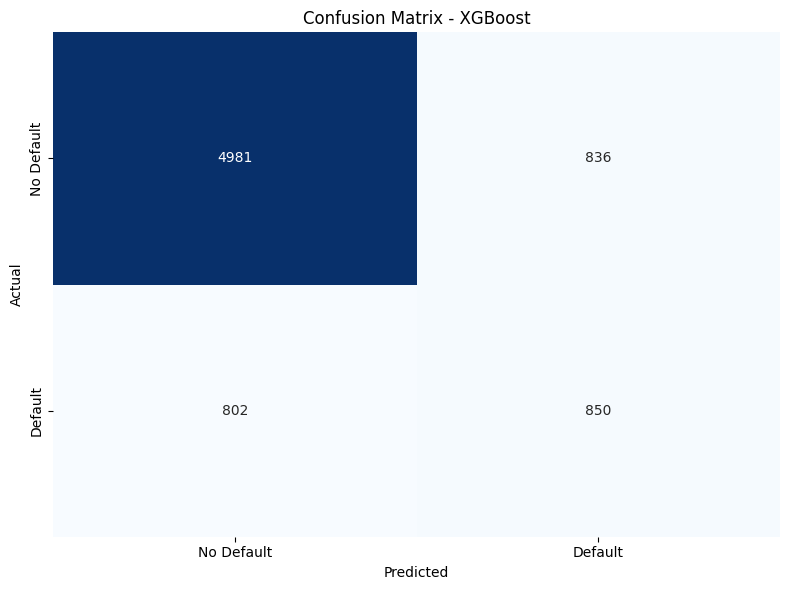

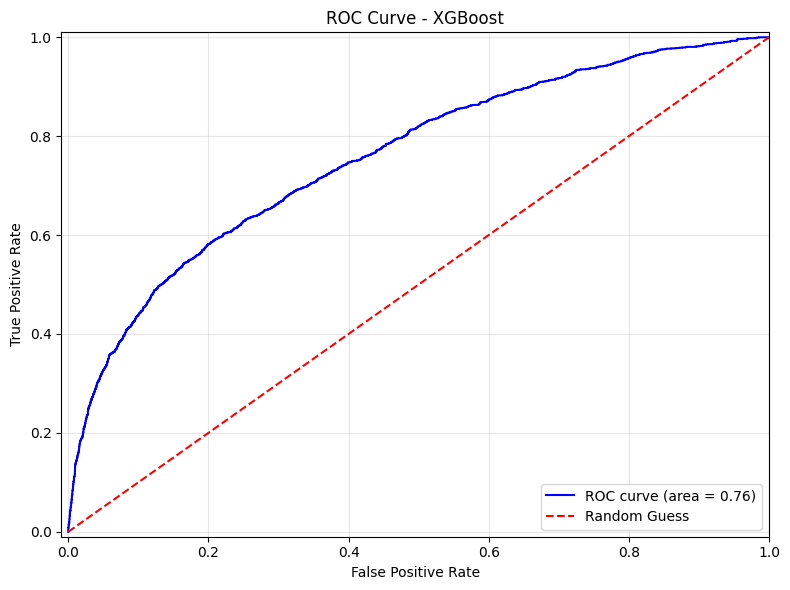

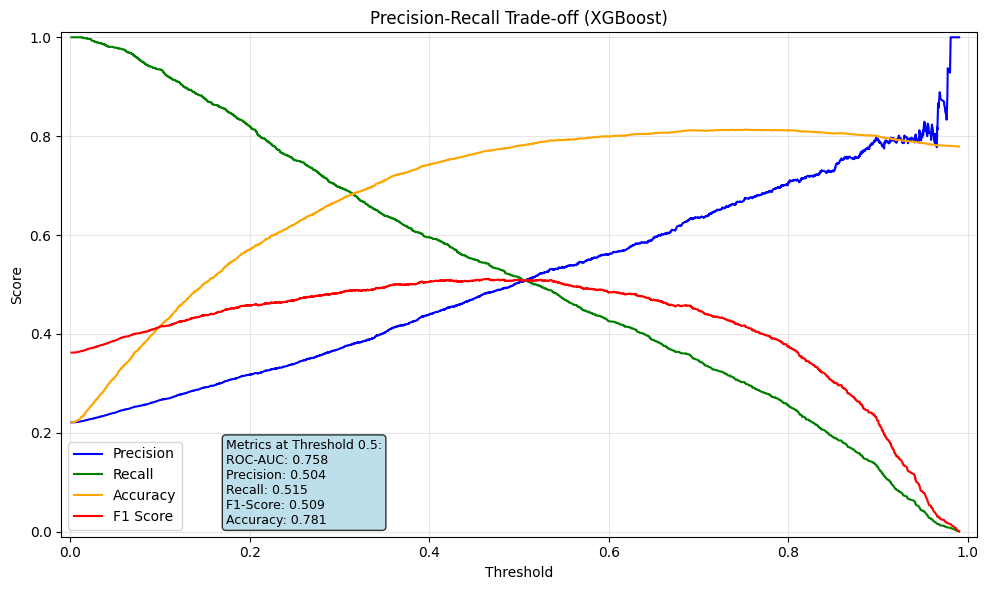

In [44]:
# Getting predicted probabilities for positive (Default) class
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Plotting the confusion matrix for XGBoost Classifier
plot_confusion_matrix(cm_xgb, model_name='XGBoost', save_path=test_performace_outputs)

# Plotting the ROC curve for XGBoost Classifier
plot_roc_curve(y_test, y_pred_proba_xgb, model_name='XGBoost', save_path=test_performace_outputs)

# Plotting the Precision-Recall Trade-off for XGBoost Classifier
plot_precision_recall_tradeoff(y_test, y_pred_proba_xgb, y_pred_xgb, model_name='XGBoost', save_path=test_performace_outputs)

- XGBoost Classifier performs decently with Area Under ROC Curve (AUC) of 76% and F1 score of 51% on test dataset.
- The model has a precision of 50% and recall of 51%, indicating low performance on test data but good balance between precision and recall.

## **Performance comparison of all models on test dataset**

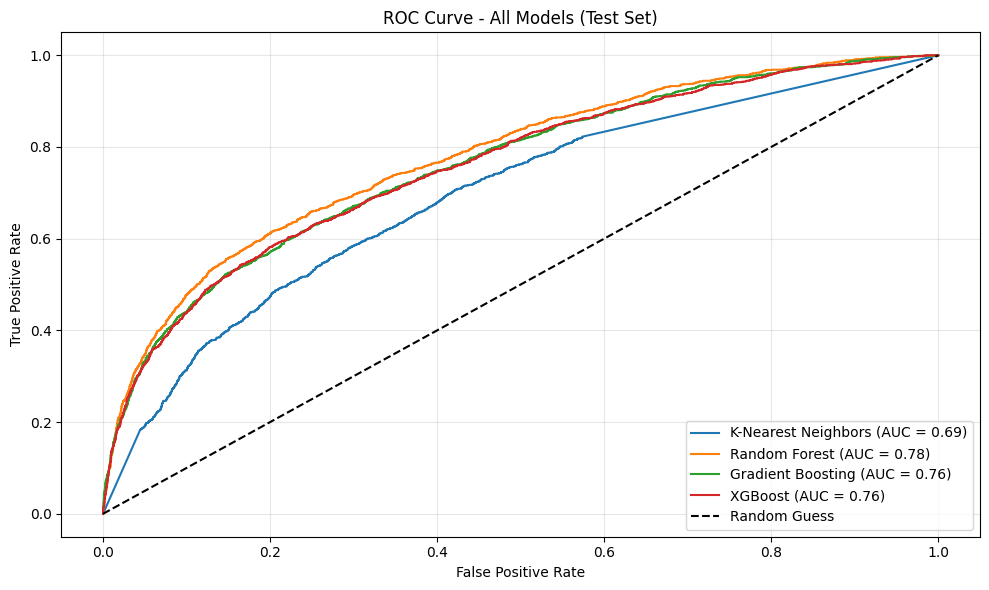

In [45]:
# Calculating fpr, tpr, and roc_auc for all models on the test set
fpr_knn, tpr_knn, roc_auc_knn = calculate_roc_auc(y_test, y_pred_proba_knn)
fpr_rf, tpr_rf, roc_auc_rf = calculate_roc_auc(y_test, y_pred_proba_rf)
fpr_gb, tpr_gb, roc_auc_gb = calculate_roc_auc(y_test, y_pred_proba_gb)
fpr_xgb, tpr_xgb, roc_auc_xgb = calculate_roc_auc(y_test, y_pred_proba_xgb)


# Plotting ROC AUC for all models on the test set
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models (Test Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(test_performace_outputs, "roc_curve_all_models_comparison.png"))
plt.show()

In [46]:
# Creating a summary dataframe for model performance on the test set
model_performance_test = {
    'Model': ['K-Nearest Neighbors', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC AUC': [roc_auc_knn, roc_auc_rf, roc_auc_gb, roc_auc_xgb],
    'Precision': [precision_knn, precision_rf, precision_gb, precision_xgb],
    'Recall': [recall_knn, recall_rf, recall_gb, recall_xgb],
    'F1 Score': [f1_knn, f1_rf, f1_gb, f1_xgb],
    'Accuracy': [accuracy_knn, accuracy_rf, accuracy_gb, accuracy_xgb]
}

model_performance_test_df = pd.DataFrame(model_performance_test)
model_performance_test_df = model_performance_test_df.round(3).sort_values(by='ROC AUC', ascending=False, ignore_index=True)

# Saving the model performance summary for the test set to a CSV file
model_performance_test_df.to_csv(os.path.join(csv_output_dir, "model_performance_summary_test.csv"), index=False)

# Displaying the model performance summary for the test set
model_performance_test_df

,Model,ROC AUC,Precision,Recall,F1 Score,Accuracy
0,Random Forest,0.777,0.570,0.483,0.523,0.805
1,Gradient Boosting,0.759,0.585,0.410,0.483,0.805
2,XGBoost,0.758,0.504,0.515,0.509,0.781
3,K-Nearest Neighbors,0.693,0.375,0.521,0.436,0.702


- Based on the performance metrics, the Random Forest Classifier, Gradient Boosting Classifier, and XGBoost Classifier performed better than KNN Classifier on test dataset.

## **Model Selection**
- Based on the performance metrics, we will select **Random Forest Classifier** as the final model for deployment. It has shown good performance on both validation and test datasets with AUC of 77.7% and F1 score of 52% on test dataset.